In [2]:
import random
import warnings
import itertools
import pmdarima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from math import sqrt
from pandas import DataFrame
from scipy import stats
from scipy.stats import boxcox
from scipy.stats import uniform
from scipy.stats import gaussian_kde as kde
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette((sns.color_palette('colorblind', 8)))
dims = (11, 8)


In [7]:
#Obtain the df data
df = pd.read_csv('http://files.zillowstatic.com/research/public_csvs/zhvi/Zip_zhvi_uc_sfr_month.csv', encoding='latin-1')
  

#look for null values 
znull=df.isnull().sum()
print("Number of Null Values:", znull.sum())
print("Number of Rows:", len(df))
print("Number of Columns:", df.shape[1])


#Summary statistics to provide a quick overview of central tendencies, shape, etc. 
df.describe()

Number of Null Values: 2068145
Number of Rows: 29532
Number of Columns: 336


,RegionID,SizeRank,RegionName,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,...,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30
count,29532.000000,29532.000000,29532.000000,1.436100e+04,1.444300e+04,1.445700e+04,1.447400e+04,1.453900e+04,1.455800e+04,1.457300e+04,...,2.952900e+04,2.953200e+04,2.953200e+04,2.952900e+04,2.953200e+04,2.953200e+04,2.911700e+04,2.951700e+04,2.953200e+04,2.953000e+04
mean,80625.565624,15610.013917,48968.889205,1.204007e+05,1.204877e+05,1.209198e+05,1.216852e+05,1.227992e+05,1.239234e+05,1.245347e+05,...,3.542915e+05,3.504990e+05,3.467543e+05,3.452526e+05,3.425020e+05,3.381479e+05,3.406108e+05,3.380681e+05,3.405875e+05,3.446391e+05
std,27106.022564,9574.237450,27188.135390,8.563012e+04,8.633345e+04,8.671382e+04,8.715987e+04,8.841158e+04,8.938863e+04,8.977148e+04,...,3.819280e+05,3.755020e+05,3.702783e+05,3.694980e+05,3.679745e+05,3.638349e+05,3.601815e+05,3.596287e+05,3.616596e+05,3.655820e+05
min,58196.000000,0.000000,1001.000000,6.011031e+03,5.864158e+03,5.717312e+03,5.409540e+03,5.096577e+03,5.021484e+03,4.877971e+03,...,1.726428e+04,1.657290e+04,1.676272e+04,1.705204e+04,1.744572e+04,1.731370e+04,2.339008e+04,2.262281e+04,2.226292e+04,2.264843e+04
25%,69059.750000,7471.750000,26489.750000,6.301331e+04,6.305124e+04,6.331483e+04,6.382691e+04,6.455626e+04,6.516388e+04,6.573716e+04,...,1.673760e+05,1.661237e+05,1.646925e+05,1.641508e+05,1.624609e+05,1.602981e+05,1.639911e+05,1.616005e+05,1.629436e+05,1.649500e+05
50%,79422.500000,15025.000000,48767.500000,9.967474e+04,9.973882e+04,1.000629e+05,1.007240e+05,1.018283e+05,1.025584e+05,1.030558e+05,...,2.552648e+05,2.535035e+05,2.513709e+05,2.503509e+05,2.482127e+05,2.450569e+05,2.482968e+05,2.461632e+05,2.482322e+05,2.515547e+05
75%,88756.250000,23281.000000,70554.250000,1.536715e+05,1.534686e+05,1.539921e+05,1.549185e+05,1.561385e+05,1.573465e+05,1.580544e+05,...,4.112460e+05,4.074604e+05,4.037747e+05,4.016802e+05,3.988150e+05,3.938153e+05,3.949497e+05,3.929100e+05,3.962121e+05,4.007363e+05
max,808739.000000,39809.000000,99929.000000,1.235552e+06,1.359899e+06,1.423386e+06,1.433793e+06,1.481305e+06,1.522158e+06,1.604038e+06,...,1.421372e+07,1.414180e+07,1.406751e+07,1.415637e+07,1.405979e+07,1.395926e+07,1.361379e+07,1.362697e+07,1.401185e+07,1.414830e+07


In [8]:
#Drop null values due to the large number of null values found rather than filling it in
df=df.dropna()
#look for null values 
znull=df.isnull().sum()
print("Number of Null Values:", znull.sum())
print("Number of Rows:", len(df))
print("Number of Columns:", df.shape[1])

Number of Null Values: 0
Number of Rows: 11689
Number of Columns: 336


In [4]:
df.head()

,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-02-29,1996-03-31,...,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30
RegionID,,,,,,,,,,,,,,,,,,,,,
61148,0,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,133406.450904,132451.459053,...,634662.946561,637055.021877,639061.343281,642200.478050,646401.814244,644122.245406,644725.041989,650206.324475,659367.445844,670031.113117
91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,182889.205724,182899.578780,...,519739.958270,516162.624473,512436.728405,508951.272090,505393.204566,500486.071906,497368.833953,499053.583916,503169.088549,507937.279377
91940,2,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,111389.390383,111383.266339,...,288355.961418,287265.377933,286268.196772,284375.562333,281962.291239,279278.529617,276999.430806,276133.935571,276987.155106,277509.746906
92593,4,78660,zip,TX,TX,Pflugerville,"Austin-Round Rock-Georgetown, TX",Travis County,176706.426846,176982.149315,...,481366.882690,472886.107936,463473.430197,454906.689792,445443.384458,436723.730092,432960.333828,431012.118172,430634.731117,431524.682777
62093,5,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,172847.634682,171983.251087,...,798961.392861,798839.585012,796124.796978,793714.138076,794575.286576,787776.147789,788440.528298,786910.524192,787788.994742,787306.573075


In [5]:
#Get a list of column names 
columns_list = df.columns.tolist()

print(columns_list)

['SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName', '1996-02-29', '1996-03-31', '1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31', '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30', '1996-12-31', '1997-01-31', '1997-02-28', '1997-03-31', '1997-04-30', '1997-05-31', '1997-06-30', '1997-07-31', '1997-08-31', '1997-09-30', '1997-10-31', '1997-11-30', '1997-12-31', '1998-01-31', '1998-02-28', '1998-03-31', '1998-04-30', '1998-05-31', '1998-06-30', '1998-07-31', '1998-08-31', '1998-09-30', '1998-10-31', '1998-11-30', '1998-12-31', '1999-01-31', '1999-02-28', '1999-03-31', '1999-04-30', '1999-05-31', '1999-06-30', '1999-07-31', '1999-08-31', '1999-09-30', '1999-10-31', '1999-11-30', '1999-12-31', '2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31', '2000-09-30', '2000-10-31', '2000-11-30', '2000-12-31', '2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30', '2001-05-31', '2001-06-3

In [6]:
#change the name of the "Region Name to ZipCode"
zillow2=df.rename(columns={'RegionName': 'ZipCode'})
#drop the RegionType column because it just let us know the 'RegionType' is a "zip"
z=zillow2.drop('RegionType', axis=1)
z=z.drop('StateName', axis=1)
z
#11689 rows × 334 columns



,SizeRank,ZipCode,State,City,Metro,CountyName,1996-02-29,1996-03-31,1996-04-30,1996-05-31,...,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30
RegionID,,,,,,,,,,,,,,,,,,,,,
61148,0,8701,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,133406.450904,132451.459053,131860.678402,131794.291256,...,6.346629e+05,6.370550e+05,6.390613e+05,6.422005e+05,6.464018e+05,6.441222e+05,6.447250e+05,6.502063e+05,6.593674e+05,6.700311e+05
91982,1,77494,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,182889.205724,182899.578780,181699.504516,185038.379311,...,5.197400e+05,5.161626e+05,5.124367e+05,5.089513e+05,5.053932e+05,5.004861e+05,4.973688e+05,4.990536e+05,5.031691e+05,5.079373e+05
91940,2,77449,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,111389.390383,111383.266339,111988.073641,111737.228669,...,2.883560e+05,2.872654e+05,2.862682e+05,2.843756e+05,2.819623e+05,2.792785e+05,2.769994e+05,2.761339e+05,2.769872e+05,2.775097e+05
92593,4,78660,TX,Pflugerville,"Austin-Round Rock-Georgetown, TX",Travis County,176706.426846,176982.149315,177188.949578,178206.443401,...,4.813669e+05,4.728861e+05,4.634734e+05,4.549067e+05,4.454434e+05,4.367237e+05,4.329603e+05,4.310121e+05,4.306347e+05,4.315247e+05
62093,5,11385,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,172847.634682,171983.251087,170672.737563,171039.531495,...,7.989614e+05,7.988396e+05,7.961248e+05,7.937141e+05,7.945753e+05,7.877761e+05,7.884405e+05,7.869105e+05,7.877890e+05,7.873066e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69057,39809,26544,WV,Maidsville,"Morgantown, WV",Monongalia County,42746.956641,43336.277924,43839.640331,44352.961854,...,1.604016e+05,1.603709e+05,1.603951e+05,1.610658e+05,1.588235e+05,1.562497e+05,1.545447e+05,1.547021e+05,1.573691e+05,1.634895e+05
98183,39809,95419,CA,Camp Meeker,"Santa Rosa-Petaluma, CA",Sonoma County,122065.290478,125971.048971,127711.664945,132853.172677,...,4.443098e+05,4.406726e+05,4.399127e+05,4.356687e+05,4.348955e+05,4.297723e+05,4.359257e+05,4.429406e+05,4.472150e+05,4.532874e+05
63511,39809,14415,NY,Bellona,"Rochester, NY",Yates County,108405.931621,106567.956384,104876.395736,105977.534522,...,1.837578e+05,1.817819e+05,1.810307e+05,1.804258e+05,1.779387e+05,1.740607e+05,1.751128e+05,1.746304e+05,1.758661e+05,1.776476e+05


In [7]:
# remove columns dates prior to 1997
zycp=['1996-02-29', '1996-03-31', '1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31', '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30', '1996-12-31']
df_1997=z.drop(columns=zycp)



In [8]:
df_1997
df_19971=df_1997.copy()

In [10]:
# check the data types of values in each column
zillow2dt = z3.dtypes

print(zillow2dt.head(15))


SizeRank        int64
ZipCode         int64
State          object
City           object
Metro          object
CountyName     object
1997-01-31    float64
1997-02-28    float64
1997-03-31    float64
1997-04-30    float64
1997-05-31    float64
1997-06-30    float64
1997-07-31    float64
1997-08-31    float64
1997-09-30    float64
dtype: object


In [11]:
#https://towardsdatascience.com/how-to-reshape-a-pandas-dataframe-98b42c428a8
import pandas as pd

# Reshape the DataFrame from wide to long format
zw = pd.melt(df_1997, id_vars=['SizeRank', 'ZipCode', 'State', 'City', 'Metro', 'CountyName'],
                      var_name='Date', value_name='HousingValue')

# Convert the 'Date' column to datetime type
zw['Date'] = pd.to_datetime(zw['Date'])

# Sort the DataFrame by date instead of SizeRank
zw = zw.sort_values('Date')

# Reset the index
zw = zw.reset_index(drop=True)
zw

#3693724 rows × 8 columns

,SizeRank,ZipCode,State,City,Metro,CountyName,Date,HousingValue
0,0,8701,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,1997-01-31,132679.641460
1,12680,26537,WV,Kingwood,"Morgantown, WV",Preston County,1997-01-31,29459.677509
2,12683,93256,CA,Pixley,"Visalia, CA",Tulare County,1997-01-31,62236.636347
3,12689,8059,NJ,Mount Ephraim,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Camden County,1997-01-31,86166.312684
4,12689,37353,TN,Mc Donald,"Cleveland, TN",Bradley County,1997-01-31,96872.727830
...,...,...,...,...,...,...,...,...
3693719,5285,27101,NC,Winston-Salem,"Winston-Salem, NC",Forsyth County,2023-04-30,203010.806503
3693720,5286,33545,FL,Wesley Chapel,"Tampa-St. Petersburg-Clearwater, FL",Pasco County,2023-04-30,436655.846107
3693721,5287,92844,CA,Garden Grove,"Los Angeles-Long Beach-Anaheim, CA",Orange County,2023-04-30,813909.232505
3693722,5289,63141,MO,Creve Coeur,"St. Louis, MO-IL",Saint Louis County,2023-04-30,708965.947642


In [12]:
zw.head(25)

,SizeRank,ZipCode,State,City,Metro,CountyName,Date,HousingValue
0,0,8701,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,1997-01-31,132679.641460
1,12680,26537,WV,Kingwood,"Morgantown, WV",Preston County,1997-01-31,29459.677509
2,12683,93256,CA,Pixley,"Visalia, CA",Tulare County,1997-01-31,62236.636347
3,12689,8059,NJ,Mount Ephraim,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Camden County,1997-01-31,86166.312684
4,12689,37353,TN,Mc Donald,"Cleveland, TN",Bradley County,1997-01-31,96872.727830
5,12693,14867,NY,Newfield,"Ithaca, NY",Tompkins County,1997-01-31,82543.398306
6,12696,19567,PA,Womelsdorf,"Reading, PA",Berks County,1997-01-31,88677.023570
7,12697,1740,MA,Bolton,"Worcester, MA-CT",Worcester County,1997-01-31,345276.931054
8,12708,19066,PA,Merion Station,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Montgomery County,1997-01-31,300194.064599
9,12677,45380,OH,Versailles,"Greenville, OH",Darke County,1997-01-31,107748.842347


In [13]:
#use regular expression to remove the comma and the state arcoynm fromthe Metro Column
zw['Metro'] = zw['Metro'].str.replace(r',.*', '', regex=True)
zw

,SizeRank,ZipCode,State,City,Metro,CountyName,Date,HousingValue
0,0,8701,NJ,Lakewood,New York-Newark-Jersey City,Ocean County,1997-01-31,132679.641460
1,12680,26537,WV,Kingwood,Morgantown,Preston County,1997-01-31,29459.677509
2,12683,93256,CA,Pixley,Visalia,Tulare County,1997-01-31,62236.636347
3,12689,8059,NJ,Mount Ephraim,Philadelphia-Camden-Wilmington,Camden County,1997-01-31,86166.312684
4,12689,37353,TN,Mc Donald,Cleveland,Bradley County,1997-01-31,96872.727830
...,...,...,...,...,...,...,...,...
3693719,5285,27101,NC,Winston-Salem,Winston-Salem,Forsyth County,2023-04-30,203010.806503
3693720,5286,33545,FL,Wesley Chapel,Tampa-St. Petersburg-Clearwater,Pasco County,2023-04-30,436655.846107
3693721,5287,92844,CA,Garden Grove,Los Angeles-Long Beach-Anaheim,Orange County,2023-04-30,813909.232505
3693722,5289,63141,MO,Creve Coeur,St. Louis,Saint Louis County,2023-04-30,708965.947642


In [14]:
#look at how the Arkansas Metro names are formatted
zw[zw['State']=='AR']['Metro']
#https://pandas.pydata.org/docs/user_guide/indexing.html?highlight=startswith
view = zw[zw['Metro'].str.startswith(('Hot Springs', 'Little Rock', 'Fayetteville', 'Searcy'))]
print(view)

         SizeRank  ZipCode State               City  \
93          12451    72727    AR             Elkins   
238         13286    28391    NC            Stedman   
241         13291    28305    NC       Fayetteville   
248         13071    72718    AR       Cave Springs   
300         12850    71968    AR              Royal   
...           ...      ...   ...                ...   
3693331      5878    72118    AR  North Little Rock   
3693354      5834    72211    AR        Little Rock   
3693447      5154    72206    AR        Little Rock   
3693659      5199    28390    NC        Spring Lake   
3693718      5284    72713    AR        Bentonville   

                                        Metro         CountyName       Date  \
93             Fayetteville-Springdale-Rogers     Madison County 1997-01-31   
238                              Fayetteville  Cumberland County 1997-01-31   
241                              Fayetteville  Cumberland County 1997-01-31   
248            Fayettev

In [15]:
#Subset of the Hot Spring Metro Area fro Arkansas
hs = zw[(zw['State'] == 'AR') & zw['Metro'].str.startswith(('Hot Springs'))]
print(hs.describe())
hs

           SizeRank       ZipCode   HousingValue
count   1896.000000   1896.000000    1896.000000
mean   14627.333333  71945.166667  102887.981893
std     5255.887210     22.761345   48834.521526
min     4063.000000  71901.000000   28711.973049
25%    12850.000000  71933.000000   68055.668380
50%    16430.500000  71952.500000   95968.016972
75%    17684.000000  71964.000000  125421.506107
max    20306.000000  71968.000000  289902.780452


,SizeRank,ZipCode,State,City,Metro,CountyName,Date,HousingValue
300,12850,71968,AR,Royal,Hot Springs,Garland County,1997-01-31,56546.553694
979,15247,71964,AR,Pearcy,Hot Springs,Garland County,1997-01-31,59952.166837
4619,17614,71949,AR,Jessieville,Hot Springs,Garland County,1997-01-31,45639.983139
5322,20306,71956,AR,Mountain Pine,Hot Springs,Garland County,1997-01-31,29936.028215
5601,17684,71933,AR,Bonnerdale,Hot Springs,Garland County,1997-01-31,58274.355786
...,...,...,...,...,...,...,...,...
3683013,15247,71964,AR,Pearcy,Hot Springs,Garland County,2023-04-30,249465.386877
3686655,17614,71949,AR,Jessieville,Hot Springs,Garland County,2023-04-30,155768.142297
3687358,20306,71956,AR,Mountain Pine,Hot Springs,Garland County,2023-04-30,142531.311291
3687637,17684,71933,AR,Bonnerdale,Hot Springs,Garland County,2023-04-30,220319.436798


In [16]:
#Subset of the Little Rock Metro Area
lr = zw[(zw['State'] == 'AR') & zw['Metro'].str.startswith(('Little Rock'))]
print(lr.describe())
lr

           SizeRank       ZipCode   HousingValue
count  12324.000000  12324.000000   12324.000000
mean   11037.692308  72120.538462  134536.306024
std     6295.898478     71.202084   70440.119418
min     1849.000000  71909.000000   24320.432493
25%     5834.000000  72076.000000   81886.263260
50%     9056.000000  72117.000000  119056.411529
75%    16030.000000  72201.000000  164262.206801
max    25903.000000  72227.000000  473537.548424


,SizeRank,ZipCode,State,City,Metro,CountyName,Date,HousingValue
350,12968,72065,AR,Hensley,Little Rock-North Little Rock-Conway,Saline County,1997-01-31,72267.781027
1201,13389,72106,AR,Mayflower,Little Rock-North Little Rock-Conway,Faulkner County,1997-01-31,68599.036914
1361,14168,72135,AR,Little Rock,Little Rock-North Little Rock-Conway,Pulaski County,1997-01-31,87706.656183
1380,13888,72024,AR,Carlisle,Little Rock-North Little Rock-Conway,Lonoke County,1997-01-31,69538.123719
1562,9210,72207,AR,Little Rock,Little Rock-North Little Rock-Conway,Pulaski County,1997-01-31,144196.465978
...,...,...,...,...,...,...,...,...
3693280,5798,72205,AR,Little Rock,Little Rock-North Little Rock-Conway,Pulaski County,2023-04-30,222987.871058
3693298,5754,72116,AR,North Little Rock,Little Rock-North Little Rock-Conway,Pulaski County,2023-04-30,233686.970548
3693331,5878,72118,AR,North Little Rock,Little Rock-North Little Rock-Conway,Pulaski County,2023-04-30,122896.527982
3693354,5834,72211,AR,Little Rock,Little Rock-North Little Rock-Conway,Pulaski County,2023-04-30,288052.160203


In [17]:
#Subset of the Fayetteville Metro Area
fv = zw[(zw['State'] == 'AR') & zw['Metro'].str.startswith(('Fayetteville'))]
print(fv.describe())
fv

           SizeRank       ZipCode   HousingValue
count  10428.000000  10428.000000   10428.000000
mean   10912.272727  72743.636364  145548.980612
std     7207.489616     43.629174   69907.728837
min      690.000000  72701.000000   22845.047608
25%     5284.000000  72718.000000   95631.768501
50%    10781.000000  72738.000000  133385.096559
75%    14807.000000  72758.000000  180846.387801
max    26709.000000  72959.000000  481917.304313


,SizeRank,ZipCode,State,City,Metro,CountyName,Date,HousingValue
93,12451,72727,AR,Elkins,Fayetteville-Springdale-Rogers,Madison County,1997-01-31,66957.395247
248,13071,72718,AR,Cave Springs,Fayetteville-Springdale-Rogers,Benton County,1997-01-31,128759.050724
344,12946,72732,AR,Garfield,Fayetteville-Springdale-Rogers,Benton County,1997-01-31,103308.632003
503,11650,72751,AR,Pea Ridge,Fayetteville-Springdale-Rogers,Benton County,1997-01-31,86721.723332
605,12359,72774,AR,West Fork,Fayetteville-Springdale-Rogers,Washington County,1997-01-31,75307.320523
...,...,...,...,...,...,...,...,...
3691812,8195,72714,AR,Bella Vista,Fayetteville-Springdale-Rogers,Benton County,2023-04-30,319638.854603
3692128,7763,72715,AR,Bella Vista,Fayetteville-Springdale-Rogers,Benton County,2023-04-30,334269.443919
3692243,7585,72745,AR,Lowell,Fayetteville-Springdale-Rogers,Benton County,2023-04-30,320963.101540
3693094,5498,72761,AR,Siloam Springs,Fayetteville-Springdale-Rogers,Benton County,2023-04-30,266308.099663


In [18]:
#Subset of the Searcy Metro Area
sy = zw[(zw['State'] == 'AR') & zw['Metro'].str.startswith(('Searcy'))]

print(sy.describe())
sy

           SizeRank       ZipCode   HousingValue
count   2528.000000   2528.000000    2528.000000
mean   14597.750000  72090.500000  101465.077983
std     6090.600874     44.660262   29454.303309
min     2412.000000  72012.000000   56006.744993
25%    10514.000000  72062.250000   79559.993799
50%    17557.000000  72091.500000   95792.640038
75%    18781.500000  72136.250000  117601.090584
max    20704.000000  72143.000000  228099.000939


,SizeRank,ZipCode,State,City,Metro,CountyName,Date,HousingValue
2126,8813,72012,AR,Beebe,Searcy,White County,1997-01-31,71693.510237
2493,11081,72081,AR,Judsonia,Searcy,White County,1997-01-31,56245.169702
4661,17136,72137,AR,Rose Bud,Searcy,White County,1997-01-31,65291.896724
5298,20424,72045,AR,Searcy,Searcy,White County,1997-01-31,68873.726051
5355,20704,72068,AR,Searcy,Searcy,White County,1997-01-31,60051.786888
...,...,...,...,...,...,...,...,...
3687334,20424,72045,AR,Searcy,Searcy,White County,2023-04-30,228099.000939
3687391,20704,72068,AR,Searcy,Searcy,White County,2023-04-30,110972.619007
3687599,18234,72136,AR,Romance,Searcy,White County,2023-04-30,201941.820853
3687665,17978,72102,AR,McRae,Searcy,White County,2023-04-30,155357.671082


In [19]:
# subest the Zillow data frame for the State Arkansas and the four spcified metros in order to find the average Housing value at the Metro level 
zwar = zw[(zw['State'] == 'AR') & zw['Metro'].str.startswith(('Hot Springs', 'Little Rock', 'Fayetteville', 'Searcy'))]
zwar

,SizeRank,ZipCode,State,City,Metro,CountyName,Date,HousingValue
93,12451,72727,AR,Elkins,Fayetteville-Springdale-Rogers,Madison County,1997-01-31,66957.395247
248,13071,72718,AR,Cave Springs,Fayetteville-Springdale-Rogers,Benton County,1997-01-31,128759.050724
300,12850,71968,AR,Royal,Hot Springs,Garland County,1997-01-31,56546.553694
344,12946,72732,AR,Garfield,Fayetteville-Springdale-Rogers,Benton County,1997-01-31,103308.632003
350,12968,72065,AR,Hensley,Little Rock-North Little Rock-Conway,Saline County,1997-01-31,72267.781027
...,...,...,...,...,...,...,...,...
3693298,5754,72116,AR,North Little Rock,Little Rock-North Little Rock-Conway,Pulaski County,2023-04-30,233686.970548
3693331,5878,72118,AR,North Little Rock,Little Rock-North Little Rock-Conway,Pulaski County,2023-04-30,122896.527982
3693354,5834,72211,AR,Little Rock,Little Rock-North Little Rock-Conway,Pulaski County,2023-04-30,288052.160203
3693447,5154,72206,AR,Little Rock,Little Rock-North Little Rock-Conway,Pulaski County,2023-04-30,107720.791500


In [20]:
#Average housing value at the metro level
avmar= zwar.groupby('Metro')['HousingValue'].mean()
avmar    

Metro
Fayetteville-Springdale-Rogers          145548.980612
Hot Springs                             102887.981893
Little Rock-North Little Rock-Conway    134536.306024
Searcy                                  101465.077983
Name: HousingValue, dtype: float64

In [21]:
# Convert the 'Date' column to datetime
zwar['Date'] = pd.to_datetime(zwar['Date'])

# Set the 'Date' column as the index
zwar.set_index('Date', inplace=True)

# Sort the index in ascending order (if necessary)
zwar.sort_index(inplace=True)

# Verify the resulting time series
print(zwar)

            SizeRank  ZipCode State               City  \
Date                                                     
1997-01-31     12451    72727    AR             Elkins   
1997-01-31     13071    72718    AR       Cave Springs   
1997-01-31     12850    71968    AR              Royal   
1997-01-31     12946    72732    AR           Garfield   
1997-01-31     12968    72065    AR            Hensley   
...              ...      ...   ...                ...   
2023-04-30      5754    72116    AR  North Little Rock   
2023-04-30      5878    72118    AR  North Little Rock   
2023-04-30      5834    72211    AR        Little Rock   
2023-04-30      5154    72206    AR        Little Rock   
2023-04-30      5284    72713    AR        Bentonville   

                                           Metro      CountyName  \
Date                                                               
1997-01-31        Fayetteville-Springdale-Rogers  Madison County   
1997-01-31        Fayetteville-Springdale

C:\Users\ksmen\AppData\Local\Temp\ipykernel_2192\2306509379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zwar['Date'] = pd.to_datetime(zwar['Date'])


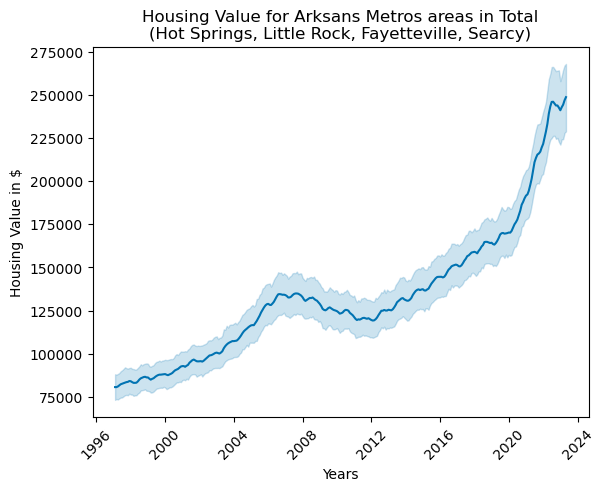

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the time series
sns.lineplot(data=zwar, x=zwar.index, y='HousingValue')

# Set the x-axis label
plt.xlabel('Years')
plt.xticks(rotation=45)

# Set the y-axis label
plt.ylabel('Housing Value in $')

# Set the plot title
plt.title('Housing Value for Arksans Metros areas in Total\n(Hot Springs, Little Rock, Fayetteville, Searcy)')

# Display the plot
plt.show()


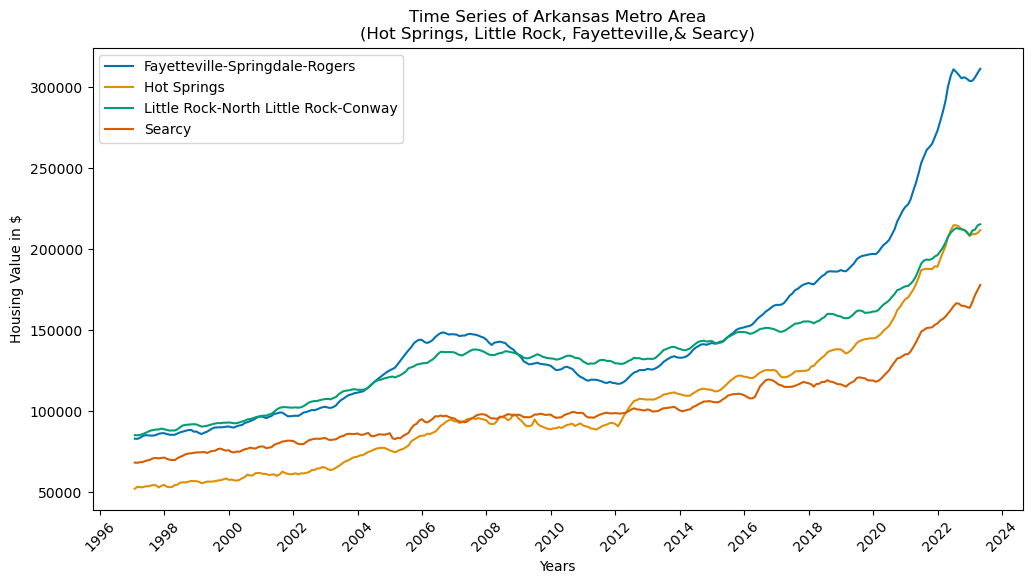

In [23]:

#https://stackoverflow.com/questions/57126647/how-to-change-xticks-to-yearly-interval-in-pandas-time-series-plot
#
plt.figure(figsize=(12, 6))  # Set the figure size
ax=sns.lineplot(data=zwar, x='Date', y='HousingValue', hue='Metro', linestyle='solid', errorbar=None)
plt.title('Time Series of Arkansas Metro Area\n(Hot Springs, Little Rock, Fayetteville,& Searcy)')
plt.xlabel('Years')
# Set x-axis ticks to be every 2 years
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=2))
# Format the x-axis tick labels as years
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
plt.ylabel('Housing Value in $')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()


In [23]:
# Group by year and calculate the mean HousingValue
average_by_year = zwar['HousingValue'].groupby(zwar.index.year).mean()

# Print the average HousingValue by each year
for year, average in average_by_year.items():
    print(f"Year: {year}, Average HousingValue: {average}")

Year: 1997, Average HousingValue: 82544.05716094057
Year: 1998, Average HousingValue: 84943.61672879904
Year: 1999, Average HousingValue: 86906.77250674003
Year: 2000, Average HousingValue: 89977.22527677123
Year: 2001, Average HousingValue: 94813.35795616024
Year: 2002, Average HousingValue: 98175.35233471291
Year: 2003, Average HousingValue: 104105.41911786847
Year: 2004, Average HousingValue: 111986.24151090816
Year: 2005, Average HousingValue: 122816.63573562352
Year: 2006, Average HousingValue: 132181.96548349046
Year: 2007, Average HousingValue: 133770.43231226955
Year: 2008, Average HousingValue: 131177.41265825543
Year: 2009, Average HousingValue: 125818.595652381
Year: 2010, Average HousingValue: 123763.78473488375
Year: 2011, Average HousingValue: 120148.21085277182
Year: 2012, Average HousingValue: 122995.64746532567
Year: 2013, Average HousingValue: 129131.42923208179
Year: 2014, Average HousingValue: 134693.13154064142
Year: 2015, Average HousingValue: 140780.7775060075
Ye

In [24]:
# Set the 'Date' column as the index
hs.set_index('Date', inplace=True)
# Group by year and calculate the mean HousingValue
average_by_yearhs = hs['HousingValue'].groupby(hs.index.year).mean()

# Print the average HousingValue by each year
for year, average in average_by_yearhs.items():
    print(f"Year: {year}, Average HousingValue: {average}")

Year: 1997, Average HousingValue: 53734.462108831525
Year: 1998, Average HousingValue: 55476.79606904334
Year: 1999, Average HousingValue: 57065.13182663753
Year: 2000, Average HousingValue: 59710.45329447929
Year: 2001, Average HousingValue: 61337.32872610105
Year: 2002, Average HousingValue: 63302.12552293659
Year: 2003, Average HousingValue: 67905.28457998895
Year: 2004, Average HousingValue: 75760.76531275491
Year: 2005, Average HousingValue: 79447.86508490847
Year: 2006, Average HousingValue: 90122.4682889586
Year: 2007, Average HousingValue: 94727.6534814711
Year: 2008, Average HousingValue: 95203.21783361379
Year: 2009, Average HousingValue: 91415.8245606525
Year: 2010, Average HousingValue: 91081.98222156256
Year: 2011, Average HousingValue: 90910.68424622499
Year: 2012, Average HousingValue: 102528.96896901044
Year: 2013, Average HousingValue: 109770.83723620251
Year: 2014, Average HousingValue: 112010.2343241859
Year: 2015, Average HousingValue: 117672.00350555482
Year: 2016,

In [25]:
# Set the 'Date' column as the index
lr.set_index('Date', inplace=True)
# Group by year and calculate the mean HousingValue
average_by_yearlr = lr['HousingValue'].groupby(lr.index.year).mean()

# Print the average HousingValue by each year
for year, average in average_by_yearlr.items():
    print(f"Year: {year}, Average HousingValue: {average}")

Year: 1997, Average HousingValue: 87437.4529572511
Year: 1998, Average HousingValue: 90317.31117642528
Year: 1999, Average HousingValue: 92085.9583832396
Year: 2000, Average HousingValue: 94680.7965931874
Year: 2001, Average HousingValue: 100608.08521818278
Year: 2002, Average HousingValue: 105137.89876089351
Year: 2003, Average HousingValue: 111158.16682962883
Year: 2004, Average HousingValue: 117468.8067797063
Year: 2005, Average HousingValue: 125348.72933135611
Year: 2006, Average HousingValue: 134312.05166169076
Year: 2007, Average HousingValue: 136592.7345337465
Year: 2008, Average HousingValue: 135859.25447554368
Year: 2009, Average HousingValue: 133651.46003922352
Year: 2010, Average HousingValue: 132941.92006659426
Year: 2011, Average HousingValue: 130512.79121837374
Year: 2012, Average HousingValue: 131466.63574269103
Year: 2013, Average HousingValue: 136787.7684499489
Year: 2014, Average HousingValue: 141275.80081202317
Year: 2015, Average HousingValue: 145810.37608473454
Yea

In [26]:
# Set the 'Date' column as the index
fv.set_index('Date', inplace=True)
# Group by year and calculate the mean HousingValue
average_by_yearfv = fv['HousingValue'].groupby(fv.index.year).mean()

# Print the average HousingValue by each year
for year, average in average_by_yearfv.items():
    print(f"Year: {year}, Average HousingValue: {average}")

Year: 1997, Average HousingValue: 85037.31597381376
Year: 1998, Average HousingValue: 87012.62002384289
Year: 1999, Average HousingValue: 88946.62864214223
Year: 2000, Average HousingValue: 93189.65918856261
Year: 2001, Average HousingValue: 97640.55610648099
Year: 2002, Average HousingValue: 100228.86884852372
Year: 2003, Average HousingValue: 107088.67991693092
Year: 2004, Average HousingValue: 118458.03526756461
Year: 2005, Average HousingValue: 136189.9257950667
Year: 2006, Average HousingValue: 146113.89945628704
Year: 2007, Average HousingValue: 146731.27695695718
Year: 2008, Average HousingValue: 140477.57834609467
Year: 2009, Average HousingValue: 129670.34870338316
Year: 2010, Average HousingValue: 125090.11604408707
Year: 2011, Average HousingValue: 118628.28042798066
Year: 2012, Average HousingValue: 122198.28584374939
Year: 2013, Average HousingValue: 130336.3432817384
Year: 2014, Average HousingValue: 138565.31575836102
Year: 2015, Average HousingValue: 146781.76217327698


In [27]:
# Set the 'Date' column as the index
sy.set_index('Date', inplace=True)
# Group by year and calculate the mean HousingValue
average_by_yearsy = sy['HousingValue'].groupby(sy.index.year).mean()

# Print the average HousingValue by each year
for year, average in average_by_yearsy.items():
    print(f"Year: {year}, Average HousingValue: {average}")

Year: 1997, Average HousingValue: 70011.25633990655
Year: 1998, Average HousingValue: 72312.33319938212
Year: 1999, Average HousingValue: 75625.06531034739
Year: 2000, Average HousingValue: 76496.10420982205
Year: 2001, Average HousingValue: 80008.89210627164
Year: 2002, Average HousingValue: 81917.10299644509
Year: 2003, Average HousingValue: 84567.42413031368
Year: 2004, Average HousingValue: 85731.69372792447
Year: 2005, Average HousingValue: 87834.43594926043
Year: 2006, Average HousingValue: 95873.19062287717
Year: 2007, Average HousingValue: 95830.3089463319
Year: 2008, Average HousingValue: 96970.89645511958
Year: 2009, Average HousingValue: 97546.97874993627
Year: 2010, Average HousingValue: 98060.61022732216
Year: 2011, Average HousingValue: 97818.73952763613
Year: 2012, Average HousingValue: 100338.70517440823
Year: 2013, Average HousingValue: 101356.94908705552
Year: 2014, Average HousingValue: 103642.03185690369
Year: 2015, Average HousingValue: 108839.00318256592
Year: 201

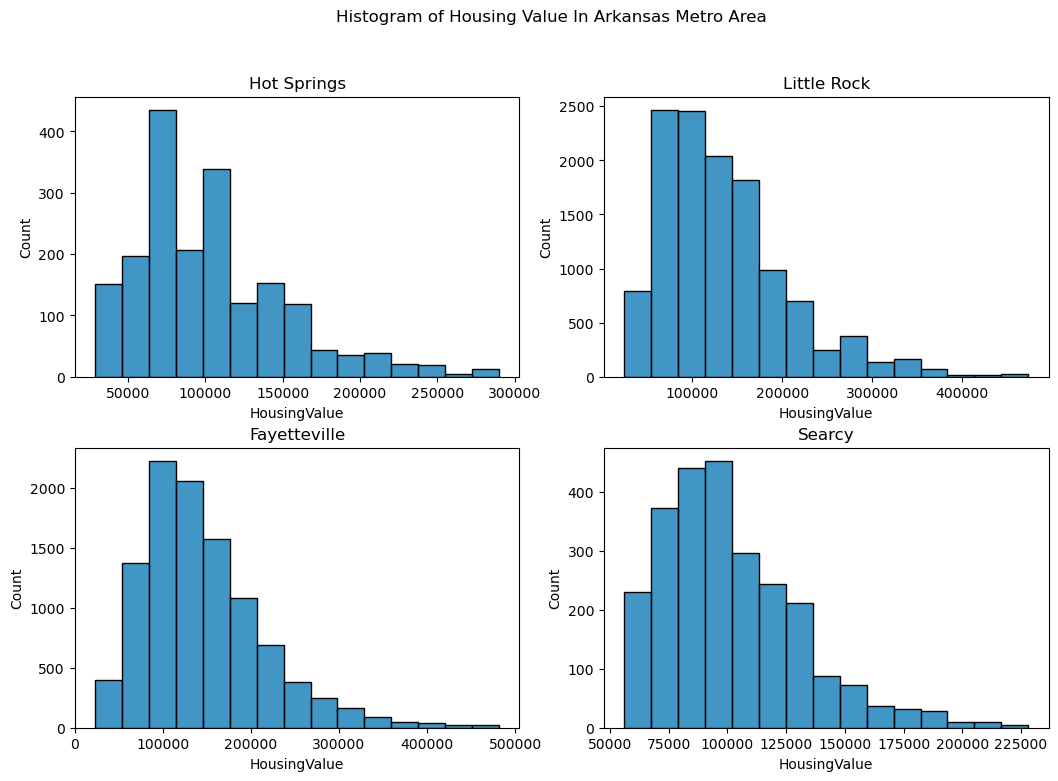

In [29]:
fig1, ax1 = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=dims)
fig1.suptitle('Histogram of Housing Value In Arkansas Metro Area')
fig1.tight_layout(pad=3)

sns.histplot(hs['HousingValue'], bins=15, ax=ax1[0][0])
ax1[0][0].set_title('Hot Springs')
ax1[0][0].ticklabel_format(style='plain', axis='x')

sns.histplot(lr['HousingValue'], bins=15, ax=ax1[0][1])
ax1[0][1].set_title('Little Rock')
ax1[0][1].ticklabel_format(style='plain', axis='x')

sns.histplot(fv['HousingValue'], bins=15, ax=ax1[1][0])
ax1[1][0].set_title('Fayetteville')
ax1[1][0].ticklabel_format(style='plain', axis='x')

sns.histplot(sy['HousingValue'], bins=15, ax=ax1[1][1])
ax1[1][1].set_title('Searcy')
ax1[1][1].ticklabel_format(style='plain', axis='x')

plt.show()


In [ ]:
#https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1